In [83]:
from pathlib import Path
from pypdf import PdfReader
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

pl_cfg = pl.Config()

In [2]:
# data I already have from the kaggle internet-movie-script dataset
df = pl.read_parquet("data/out/internet-movie-script.parquet")

### Load Data In

In [3]:
additional_script_pdfs = list(Path("data/in/").glob("*.pdf"))
print(len(additional_script_pdfs), " new scripts.\n")
print("\n".join([p.name for p in additional_script_pdfs]))

52  new scripts.

It's a Wonderful Life.pdf
Oppenheimer.pdf
All Quiet On The Western Front.pdf
Seven Samurai.pdf
Gladiator 2.pdf
The Northman.pdf
The-Batman.pdf
Wonka.pdf
Moana 2.pdf
The Silence of the Lambs.pdf
Twisters.pdf
12 Angry Men.pdf
The Shawshank Redemption.pdf
Avengers Endgame.pdf
The Matrix.pdf
Inside Out 2.pdf
The Godfather Part II.pdf
Deadpool & Wolverine.pdf
Star Wars- Episode V - The Empire Strikes Back.pdf
The Godfather.pdf
Goodfellas.pdf
Harry Potter and the Half-Blood Prince.pdf
Encanto.pdf
The Lord of the Rings- The Return of the King.pdf
Saving Private Ryan.pdf
Inside Out.pdf
Top Gun Maverick.pdf
Fight Club.pdf
Avatar.pdf
Amsterdam.pdf
Pulp Fiction.pdf
Luca.pdf
Schindler's List.pdf
Nope.pdf
Barbie.pdf
Elvis.pdf
Se7en.pdf
The Holdovers.pdf
Bros.pdf
The Dark Knight.pdf
Forrest Gump.pdf
Pinocchio.pdf
Elemental.pdf
The Lord of the Rings- The Fellowship of the Ring.pdf
Cidade de Deus (City of God).pdf
Spider-Man No Way Home.pdf
One Flew Over the Cuckoo's Nest.pdf
Black-P

Open PDF and extract text

In [4]:
def read_script_from_pdf(pdf_filepath: str | Path) -> str:
    reader = PdfReader(pdf_filepath)
    return "\n".join( [page.extract_text() for page in reader.pages] )

In [5]:
add = pl.DataFrame({"filepath": additional_script_pdfs})\
    .with_columns(
        # get movie title from filename
        movie_title = pl.col("filepath").map_elements(lambda x: x.stem, return_dtype=pl.String)\
            # remove dashes and underscores
            # replace multiple whitespace with singular
            .str.replace_all(r'[-_\s]+', " ",) \
            # remove trailing and leading whitespace
            .str.replace_all(r'^\s+|\s+$', ""),
        # open PDF and read extract the text
        script = pl.col("filepath").map_elements(read_script_from_pdf, return_dtype=pl.String)
    )

# Data Validation

Check for issues loading text from PDF

## 1. Script Length

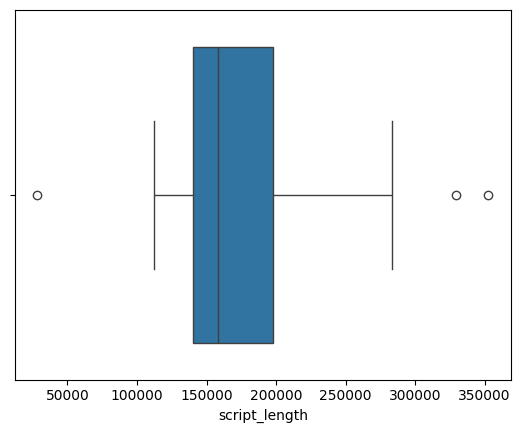

index,filepath,movie_title,script,script_length
u32,object,str,str,u32
10,data/in/Twisters.pdf,"""Twisters""","""Twisters Screenplay by Noah Pf…",28388
25,data/in/Inside Out.pdf,"""Inside Out""","""INSIDE OUT original story by P…",112584
4,data/in/Gladiator 2.pdf,"""Gladiator 2""","""GLADIATOR 2 by Nick Cave G…",112925


...


index,filepath,movie_title,script,script_length
u32,object,str,str,u32
40,data/in/Forrest Gump.pdf,"""Forrest Gump""",""" …",283204
3,data/in/Seven Samurai.pdf,"""Seven Samurai""","""SEVEN SAMURAI Written by Akira…",329726
9,data/in/The Silence of the Lambs.pdf,"""The Silence of the Lambs""","""THE SILENCE OF THE LAMBS by Te…",352653


In [9]:
# is the script a strange length?

add = add.with_columns(
    pl.col("script").str.len_chars().alias("script_length")
)
sns.boxplot(
    x = add["script_length"]
)
plt.show()

display(
    add.with_row_index().sort("script_length").head(3)
)
print("...")
display(
    add.with_row_index().sort("script_length").tail(3)
)

Let's check the shortest script in the dataset

Looks fine to me

In [16]:
shortest_script = add.filter(pl.col("script_length") == add["script_length"].min())[0, "script"]
print(shortest_script[:300])
print("...")
print(shortest_script[-300:])

Twisters
Screenplay by
Noah Pfister
Story by
Ryan Bleau & Alex Ross & Colin Kegliarty
and
Noah Pfister & Donald Pfister
Opening Credits
TITLE CARD: TWISTERS
BLACKNESS
TRISTAN (V.O.)
What happened to us? Where did we
go wrong.
SLOWLY OPEN TO:
INT. ABANDONED HOUSE - NIGHT
Tristan is sitting on the flo
...
ow that we have that settled,
let’s go enjoy our new home.
Tristan picks up all of his gear and makes his way forward.
Julia picks up her things and follows Tristan.
As they walk away, a big building can be seen in the
distance. It looks almost like...
A mall.
CUT TO BLACK.
Roll ending credits.
End.


Now the longest

Looks normal

In [10]:
longest_script = add.filter(pl.col("script_length") == add["script_length"].max())[0, "script"]
print(longest_script[:300])
print("...")
print(longest_script[-300:])

THE SILENCE OF THE LAMBS
by
Ted Tally
Based on the novel by
Thomas Harris
This screenplay has been converted to a PDF file by ScreenTalk™
http://www.screentalk.org
FADE IN:FADE IN:
INT. GRUBBY HOTEL CORRIDOR - DAY (DIMLY LIT)INT. GRUBBY HOTEL CORRIDOR - DAY (DIMLY LIT)
A woman's face BACKS INTO SHOT
...
ders him for a genial moment, then raises the littleConsiders him for a genial moment, then raises the little
pen-knife. His eyes are twinkling.pen-knife. His eyes are twinkling.
DR. LECTERDR. LECTER
Well, Dr. Chilton. Shall we begin?Well, Dr. Chilton. Shall we begin?
FADE OUTFADE OUT
THE ENDTHE END


## 2. Non Alphanumeric Characters

Let's make sure none of the scripts are filled with pdf relics

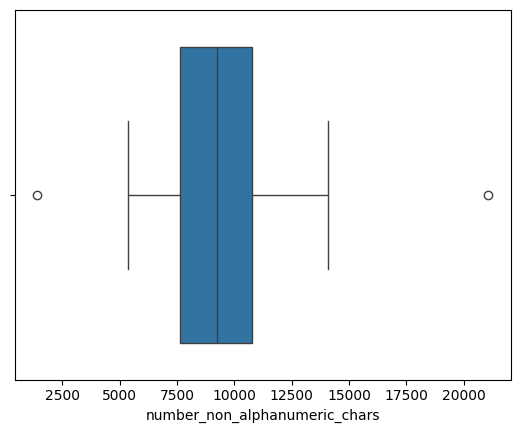

index,filepath,movie_title,script,script_length,number_non_alphanumeric_chars
u32,object,str,str,u32,u32
9,data/in/The Silence of the Lambs.pdf,"""The Silence of the Lambs""","""THE SILENCE OF THE LAMBS by Te…",352653,21078
6,data/in/The-Batman.pdf,"""The Batman""","""Rev. 12/17/20 (Blue) THE BATM…",195691,14096
45,data/in/Spider-Man No Way Home.pdf,"""Spider Man No Way Home""","""Written as Written by Chris Mc…",205954,13349
47,data/in/Black-Panther-Wakanda-Forever.pdf,"""Black Panther Wakanda Forever""","""SUMMER BREAK Written by Ryan C…",236468,13250
35,data/in/Elvis.pdf,"""Elvis""","""ELVIS Screenplay by BAZ LUHRMA…",218351,12944


In [11]:
add = add.with_columns(
    pl.col("script").str.count_matches(r'[^A-z0-9\s]')
    .alias("number_non_alphanumeric_chars")
)

sns.boxplot(
    x = add["number_non_alphanumeric_chars"]
)
plt.show()

add.with_row_index().sort("number_non_alphanumeric_chars", descending=True)\
    .head()

The script doesn't look damaged to me

In [12]:
most_punctuation_chars = add.filter(pl.col("number_non_alphanumeric_chars") == add["number_non_alphanumeric_chars"].max())[0, "script"]
print(most_punctuation_chars[:300])
print("...")
print(most_punctuation_chars[-300:])

THE SILENCE OF THE LAMBS
by
Ted Tally
Based on the novel by
Thomas Harris
This screenplay has been converted to a PDF file by ScreenTalk™
http://www.screentalk.org
FADE IN:FADE IN:
INT. GRUBBY HOTEL CORRIDOR - DAY (DIMLY LIT)INT. GRUBBY HOTEL CORRIDOR - DAY (DIMLY LIT)
A woman's face BACKS INTO SHOT
...
ders him for a genial moment, then raises the littleConsiders him for a genial moment, then raises the little
pen-knife. His eyes are twinkling.pen-knife. His eyes are twinkling.
DR. LECTERDR. LECTER
Well, Dr. Chilton. Shall we begin?Well, Dr. Chilton. Shall we begin?
FADE OUTFADE OUT
THE ENDTHE END


Very reasonable punctuation characters

In [13]:
import re
from collections import Counter

matches = re.findall(r'[^A-z0-9\s]', most_punctuation_chars)

non_alphanumeric_counts_sotl = Counter(matches)

non_alphanumeric_counts_sotl

Counter({'.': 9322,
         ',': 5326,
         "'": 1910,
         '-': 1514,
         '(': 730,
         ')': 730,
         '?': 662,
         ':': 309,
         '"': 224,
         '!': 206,
         ';': 128,
         '/': 8,
         '&': 6,
         '$': 2,
         '™': 1})

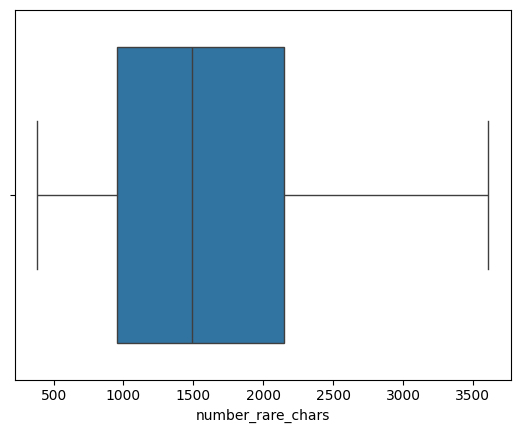

index,filepath,movie_title,script,script_length,number_non_alphanumeric_chars,number_rare_chars
u32,object,str,str,u32,u32,u32
47,data/in/Black-Panther-Wakanda-Forever.pdf,"""Black Panther Wakanda Forever""","""SUMMER BREAK Written by Ryan C…",236468,13250,3611
17,data/in/Deadpool & Wolverine.pdf,"""Deadpool & Wolverine""","""TIDAL WAVE Ryan Reynolds & Zeb…",174684,12176,3471
11,data/in/12 Angry Men.pdf,"""12 Angry Men""","""1. NOTE: The notes on characte…",157913,10495,3200
38,data/in/Bros.pdf,"""Bros""",""" BROS Writte…",155965,8143,3089
31,data/in/Luca.pdf,"""Luca""","""LUCA Original Screenplay by Je…",132094,8683,2788


In [14]:
rare_chars_regex = r'[^A-Za-zÀ-ÖØ-öø-ÿ0-9\s\.\,\;\'\"\-\_\(\)]'

add = add.with_columns(
    pl.col("script").str.count_matches(rare_chars_regex)
    .alias("number_rare_chars")
)

sns.boxplot(
    x = add["number_rare_chars"]
)
plt.show()

add.with_row_index().sort("number_rare_chars", descending=True)\
    .head()

No issues here, looks like Wakanda Forever had a lot of revisions probably

(The script was titled "Summer Break" by the author for secrecy)

In [15]:
most_rare_chars = add.filter(pl.col("number_rare_chars") == add["number_rare_chars"].max())[0, "script"]

matches = re.findall(rare_chars_regex, most_rare_chars)

rare_counts = Counter(matches)

display(rare_counts)

print(most_rare_chars[:300])
print("...")
print(most_rare_chars[-300:])

Counter({'’': 1109,
         '/': 1055,
         '*': 810,
         '?': 394,
         '!': 160,
         '“': 22,
         '”': 21,
         ':': 19,
         '#': 10,
         '%': 4,
         '$': 4,
         '–': 2,
         '…': 1})

SUMMER BREAK
Written by
Ryan Coogler and Joe Robert Cole
Based on, Characters Created by Stan Lee and Jack Kirby
May 8, 2021
PROLOGUE
INT. SHURI’S LAB - WDG - 2025 (ONE YEAR AFTER ENDGAME)1 1
SHURI (20s) storms into her lab moving with frantic urgency. 
LIGHT PROJECTIONS of several DOUBLE HELIX DNA 
...
NT
My name is Prince T’Challa, son of 
King T’Challa. 
Shuri looks back at young T’Challa, her eyes welling with 
tearful joy as a gentle breeze passes. 
Taking it in, Shuri closes her eyes and sees her brother 
T’CHALLA, smiling at her, she smiles back as we. 
CUT TO BLACK.
Tan Rev. (02/23/22) 161.


# Combining Data into Final Dataset

1. Add alphabetized movie title

In [16]:
# create alphabetized movie title
add = add.with_columns(
    movie_title_alphabetical = pl.when(
        # when the movie title starts with 'The'
        pl.col("movie_title").str.contains(r'(?i)^the')
    )
    # move 'The' to the end
    # (remove whitespace in the interim)
    .then(pl.col("movie_title").str.replace(r'(?i)^the', '').str.replace_all(r'^\s+|\s+$', "") + pl.lit(" The"))
    .otherwise(pl.col("movie_title"))
)

add.filter(pl.col("movie_title").str.contains("The", literal=True))\
    .select(pl.col("movie_title", "movie_title_alphabetical")).head()

movie_title,movie_title_alphabetical
str,str
"""All Quiet On The Western Front""","""All Quiet On The Western Front"""
"""The Northman""","""Northman The"""
"""The Batman""","""Batman The"""
"""The Silence of the Lambs""","""Silence of the Lambs The"""
"""The Shawshank Redemption""","""Shawshank Redemption The"""


2. Concatenate with kaggle internet-movie-script dataset

In [17]:
df_dropped = df.drop(pl.col(
    "sr.no", 
    "comma_count", 
    "script_length", 
    "fraction_commas",
    "script_original",
    "date_original"
)).with_columns(
    dataset = pl.lit("https://www.kaggle.com/datasets/prasad22/the-internet-movie-script-dataset")
)
add_out = add.drop(pl.col(
    "filepath",
    "script_length",
    "number_non_alphanumeric_chars",
    "number_rare_chars"
)).with_columns(
    writers = pl.lit(None).cast(pl.String),
    genre = pl.lit(None).cast(pl.String),
    date = pl.lit(None).cast(pl.Date),
    dataset = pl.lit("Google Search")
).select(pl.col(df_dropped.columns))

dfout = pl.concat([df_dropped, add_out])\
    .select(pl.col("movie_title", "date", "script", "genre", "writers", "movie_title_alphabetical", "dataset"))\
    .sort(pl.col("movie_title_alphabetical"))\
    .with_row_index()
dfout.head()

index,movie_title,date,script,genre,writers,movie_title_alphabetical,dataset
u32,str,date,str,str,str,str,str
0,"""12 Angry Men""",null,"""1. NOTE: The notes on characte…",null,null,"""12 Angry Men""","""Google Search"""
1,"""15 Minutes""",null,"""FADE IN on the words CZECH…","""Action,Crime,Thriller""","""John Hertzfield""","""15 Minutes""","""https://www.kaggle.com/dataset…"
2,"""2012""",2008-02-01,"""OVER BLACK …","""Action,Adventure,Drama,Sci-Fi,…","""Roland Emmerich,Harald Kloser""","""2012""","""https://www.kaggle.com/dataset…"
3,"""30 Minutes or Less""",2009-12-01,"""The following is very loosely …","""Action,Adventure,Comedy""","""Michael Diliberti,Matthew Sull…","""30 Minutes or Less""","""https://www.kaggle.com/dataset…"
4,"""48 Hrs""",null,"""FADE IN: OPEN…","""Action,Comedy,Thriller""","""Steven E. De Souza,Walter Hill…","""48 Hrs""","""https://www.kaggle.com/dataset…"


Check for duplicates

**1 duplicate!**

In [18]:
dfout = dfout.with_columns(
    pl.col("movie_title").str.to_lowercase().str.replace_all(r'[^a-z0-9]', "")\
        .alias("collapsed_movie_title")
)
dfout.filter(pl.col("collapsed_movie_title").is_duplicated())

index,movie_title,date,script,genre,writers,movie_title_alphabetical,dataset,collapsed_movie_title
u32,str,date,str,str,str,str,str,str
20,"""Avengers Endgame""",null,"""FOR YOUR CONSIDERATION BEST AD…",null,null,"""Avengers Endgame""","""Google Search""","""avengersendgame"""
21,"""Avengers: Endgame""",2019-04-01,"""AVENGERS: ENDGAME …","""Action,Adventure,Drama""","""Christopher Markus,Stephen McF…","""Avengers: Endgame""","""https://www.kaggle.com/dataset…","""avengersendgame"""


Let's keep the script from the google search, but the metadata of the kaggle dataset

In [19]:
print(len(dfout[20, "script"]))
print(len(dfout[21, "script"]))


153381
34014


In [20]:
for column in ["movie_title", "date", "genre", "writers"]:
    # copy over data
    dfout[20, column] = dfout[21, column]

# filter out the duplicate then reset row index
dfout = dfout.filter(pl.col("index") != 21).drop(pl.col("index")).with_row_index()

# Add Release Year

We bring in an alternate data source to add the release year and genres to the rows where we are missing those values.

In [21]:
imdb = pl.scan_csv("data/in/imdb-movie-dataset-title-basics.tsv", 
    separator='\t',
    null_values = {"startYear": '\\N', "endYear": '\\N'},
    quote_char=None,
    schema_overrides={
        "titleType": pl.String,
        "primaryTitle": pl.String,
        "originalTitle": pl.String,
        "startYear": pl.Int16,
        "endYear": pl.Int16,
        "genres": pl.String,
        "runtimeMinutes": pl.Int32
    },
    ignore_errors=True
)

imdb_filtered_joinable = imdb.filter(
    (pl.col("titleType").str.to_lowercase() == pl.lit("movie")) & \
    (pl.col("startYear").is_not_null())
).with_columns(
    pl.col("primaryTitle").cast(pl.String, strict=False).str.to_lowercase()
    .str.replace_all(r'[\.\:\-\_\(\)]', ' ').str.replace_all(r'\s+', ' ')
    .alias("join_movie_title")
).collect()

dfx = dfout.filter(pl.col("date").is_null() | pl.col("genre").is_null())\
    .with_columns(
        pl.col("movie_title").str.to_lowercase()
        .str.replace_all(r'[\.\:\-\_\(\)]', ' ').str.replace_all(r'\s+', ' ')
        .alias("join_movie_title")
    ).join(
        imdb_filtered_joinable,
        on = "join_movie_title",
        how="left"
    )

print(
    dfx["startYear"].is_null().sum(),
    "movies still missing release year"
)

4 movies still missing release year


In [31]:
dupd = dfx.filter(pl.col("index").is_duplicated()).sort(pl.col("index", "startYear"))

print(len(set(dupd["index"])), " individual movies with duplicate joins")

print(dupd.shape[0], " total duplicates")

display(
    dupd.select(pl.col("movie_title", "primaryTitle", "startYear", "date", "titleType", "genres", "dataset")).head()
)

18  individual movies with duplicate joins
67  total duplicates


movie_title,primaryTitle,startYear,date,titleType,genres,dataset
str,str,i16,date,str,str,str
"""15 Minutes""","""15 Minutes""",1997,null,"""movie""","""\N""","""https://www.kaggle.com/dataset…"
"""15 Minutes""","""15 Minutes""",2001,null,"""movie""","""Action,Crime,Drama""","""https://www.kaggle.com/dataset…"
"""All Quiet On The Western Front""","""All Quiet on the Western Front""",1930,null,"""movie""","""Drama,War""","""Google Search"""
"""All Quiet On The Western Front""","""All Quiet on the Western Front""",2022,null,"""movie""","""Drama,History,War""","""Google Search"""
"""Amsterdam""","""Amsterdam""",2013,null,"""movie""","""Thriller""","""Google Search"""


In [32]:
correct = {
    "All Quiet On The Western Front": 2022,
    "Amsterdam": 2022,
    "15 Minutes": 2001,
    "Avatar": 2009,
    "Barbie": 2023,
    "Elemental": 2023,
    "Elvis": 2022,
    "Fight Club": 1999,
    "Harry Potter and the Half Blood Prince": 2009,
    "Inception": 2010,
    "Inside Out": 2015,
    "It's a Wonderful Life": 1946,
    "The Lord of the Rings The Fellowship of the Ring": 2001,
    "Luca": 2021,
    "Pinocchio": 2022,
    "Star Wars Episode V The Empire Strikes Back": 1980,
    "Top Gun": 1986
}

dfxc = dfx.with_columns(
    correct = pl.col("movie_title").replace_strict(correct, default=-1) \
        == pl.col("startYear")
).filter(
    ~pl.col("index").is_duplicated() | pl.col("correct")
)
dfxc.shape

(57, 20)

In [46]:
dfoutx = dfout.join(
    dfxc.select("index", "startYear", "genres"),
    how="left",
    on="index"
).with_columns(
    year_from_date = pl.col("date").dt.year()
).with_columns(
    year = pl.coalesce(["year_from_date", "startYear"])
).drop(pl.col("year_from_date", "startYear"))

In [53]:
display(
    dfoutx.filter(pl.col("year").is_null()).select(pl.col("index", "movie_title"))
)

manual_additions = [
    (4, 1982),
    (32, 2002),
    (49, 2024),
    (70, 2003),
    (104, 1986),
]

for idx, year in manual_additions:
    dfoutx[idx, "year"] = year

index,movie_title
u32,str
4,"""48 Hrs"""
32,"""Cidade de Deus (City of God)"""
49,"""Gladiator 2"""
70,"""The Lord of the Rings The Retu…"
104,"""Transformers: The Movie"""


In [91]:
dfoutx = dfoutx.with_columns(
    pl.concat_str([pl.col("genre"), pl.lit(","), pl.col("genres")], ignore_nulls=True)
    .str.replace_all(r'[^A-z\,]', "")
    .str.replace_all(r'^,|,$', "")
    .str.split(",").map_elements(lambda x: list(set(x)))
    .list.sort()
    .list.join(",")
    .replace("", None)
    .alias("genre")
)\
    .drop("genres")

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


In [94]:
dfoutx.write_parquet("data/out/movie-script-dataset.parquet")